In [1]:
#2409:8950:600:8abe:bd00:302:c61f:ee17

# 配置tensorflow利用显存方式
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.3
config.gpu_options.allow_growth=True 
#config.gpu_options.visible_device_list = "0"
set_session(tf.Session(config=config))

import copy
import time
import pickle
import numpy as np
import pandas as pd
from keras import backend as K
from keras import optimizers
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda, Activation, Conv1D, Flatten
from keras.optimizers import SGD, Adam, RMSprop
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.externals import joblib


def get_embdinspan(embds, spans, wordslabel, span):
    for idxs in range(len(spans)):
        s = spans[idxs]
        if s[0]<=span[0] and span[0]<s[1]:
            break
    for idxe in range(len(spans)):
        s = spans[idxe]
        if s[0]<=span[1] and span[1]<=s[1]:
            break
    idxe = idxe + 1
    embdsin = []
    labelsin = []
    for idx in range(idxs,idxe):
        embdsin.append(embds[idx])
        labelsin.append(wordslabel[idx])
    return embdsin, labelsin

def get_embdoutspan(embds, spans, wordslabel, span):
    for idxs in range(len(spans)):
        s = spans[idxs]
        if s[0]<=span[0] and span[0]<=s[1]:
            break
    for idxe in range(len(spans)):
        s = spans[idxe]
        if s[0]<=span[1] and span[1]<=s[1]:
            break
    embdsout = []
    labelsout = []
    for idx in range(0,idxs):
        embdsout.append(embds[idx])
        labelsout.append(wordslabel[idx])
    for idx in range(idxe,len(wordslabel)):
        embdsout.append(embds[idx])
        labelsout.append(wordslabel[idx])
    return embdsout, labelsout

def get_embdintype(embds, spans, wordslabel, labelType='NULL'):
    embds_NULL = []
    labels_NULL = []
    for idx in range(len(spans)):
        if wordslabel[idx]==labelType:
            embds_NULL.append(embds[idx])
            labels_NULL.append(wordslabel[idx])
    return embds_NULL, labels_NULL

def get_words(doc, bc): 
    '''get: words, embedding, spans, labels
    '''    
    words = []
    wordsvec = []
    spans = []
    wordslabel = []
    
    for sent in doc.sentences:
        str_sent = sent.line        
        # Embeddings of each sentence/ sequence via BERT.
        vec = bc.encode([str_sent], show_tokens=True)
        #print(type(vec))
        for idx_sentence in range(len(vec[1])):
            #print('\n',vec[1][idx_sentence])
            for idx_token in range(len(vec[1][idx_sentence])):
                #print(vec[1][idx_sentence][idx_token],'\t', vec[0][idx_sentence][idx_token][0:5])
                if( vec[1][idx_sentence][idx_token].find('[CLS]', 0, 5)==0 ):
                    # [CLS]
                    words.append(vec[1][idx_sentence][idx_token])
                    wordsvec.append(vec[0][idx_sentence][idx_token][0:])
                    if len(spans)>0:
                        spans.append([spans[-1][1],spans[-1][1]])
                    else:
                        spans.append([0,0])
                    wordslabel.append(['[CLS]'])
                elif( vec[1][idx_sentence][idx_token].find('[SEP]', 0, 5)==0 ):
                    # [SEP]
                    words.append(vec[1][idx_sentence][idx_token])
                    wordsvec.append(vec[0][idx_sentence][idx_token][0:])
                    if len(spans)>0:
                        spans.append([spans[-1][1],spans[-1][1]])
                    else:
                        spans.append([0,0])
                    wordslabel.append(['[SEP]'])
                elif( vec[1][idx_sentence][idx_token].find('##', 0, 2)<0 ):
                    # Token in BERT table
                    words.append(vec[1][idx_sentence][idx_token])
                    wordsvec.append(vec[0][idx_sentence][idx_token][0:])
                    start = doc.text.lower().find(words[-1], spans[-1][0]) + idx_sentence
                    end = start + len(words[-1]) + idx_sentence
                    spans.append([start, end])
                    label = list(set(doc.getlabelinspan(start, end)))
                    if len(str(label))>2:
                        wordslabel.append(label)
                    else:
                        wordslabel.append(['NULL'])
                else:
                    # Token started with '##' in BERT
                    words[-1] = words[-1] + vec[1][idx_sentence][idx_token][2:]
                    wordsvec[-1] = wordsvec[-1] + vec[0][idx_sentence][idx_token][0:]
                    spans[-1] = ([spans[-1][0], spans[-1][0]+len(words[-1])])
                    label = list(set(doc.getlabelinspan(spans[-1][0], spans[-1][1])))
                    if len(str(label))>2:
                        wordslabel[-1] = label
                    else:
                        wordslabel[-1] = ['NULL']
                #print(spans[-1], wordslabel[-1], words[-1], wordsvec[-1])
    return words, wordsvec, spans, wordslabel


def get_embd(sents, bc):
    '''get embedding of sents
    ''' 
    words = []
    wordsvec = []

    for str_sent in sents:
        # Embeddings of each sentence/ sequence via BERT.
        print(str_sent)
        vec = bc.encode([str_sent], show_tokens=True)
        #print(type(vec))
        for idx_sentence in range(len(vec[1])):
            #print('\n',vec[1][idx_sentence])
            for idx_token in range(len(vec[1][idx_sentence])):
                #print(vec[1][idx_sentence][idx_token],'\t', vec[0][idx_sentence][idx_token][0:5])
                if( vec[1][idx_sentence][idx_token].find('[CLS]', 0, 5)==0 ):
                    # [CLS]
                    continue
                    words.append(vec[1][idx_sentence][idx_token])
                    wordsvec.append(vec[0][idx_sentence][idx_token][0:])
                elif( vec[1][idx_sentence][idx_token].find('[SEP]', 0, 5)==0 ):
                    # [SEP]
                    continue
                    words.append(vec[1][idx_sentence][idx_token])
                    wordsvec.append(vec[0][idx_sentence][idx_token][0:])
                elif( vec[1][idx_sentence][idx_token].find('##', 0, 2)<0 ):
                    # Token in BERT table
                    words.append(vec[1][idx_sentence][idx_token])
                    wordsvec.append(vec[0][idx_sentence][idx_token][0:])  
                else:
                    # Token started with '##' in BERT
                    words[-1] = words[-1] + vec[1][idx_sentence][idx_token][2:]
                    wordsvec[-1] = wordsvec[-1] + vec[0][idx_sentence][idx_token][0:]
                #print(spans[-1], wordslabel[-1], words[-1], wordsvec[-1])
    return words, wordsvec


def get_events(doc, bc):
    '''get: triggers, embds_triggers, labels_triggers, args, embds_args, labels_args
            embeddings of arg is the concatation of trigger and arg
    ''' 
    words, wordsvec, spans, wordslabel = get_words(doc, bc)
    wordslabel = [label[0] for label in wordslabel]
    #print('labels:', len(set(wordslabel)), set(wordslabel))
    #print([[words[idx], wordslabel[idx], spans[idx]] for idx in np.arange(len(wordslabel))])
    names=['triggers', 'embds_triggers', 'labels_triggers', 'args', 'embds_args', 'labels_args', 'espan'] 
    events = pd.DataFrame(columns=names)
    idx = 0
    
    for event in doc.events:
        triggers, embds_triggers, labels_triggers, args, embds_args, labels_args, espan= [], [], [], [], [], [], []
        embdsin, labelsin = get_embdinspan(wordsvec, spans, wordslabel, event.trigger_spans)
        espan = event.trigger_spans # assume that only one trigger for one event mention
        for ebd in embdsin:
            triggers.append(event.trigger)
            embds_triggers.append(ebd)
            labels_triggers.append(event.trigger_label)
        for idx in range(len(event.args)):
            arg = event.args[idx]
            span = event.args_spans[idx]
            espan[0] = np.min([espan[0], span[0]])
            espan[1] = np.max([espan[1], span[1]])
            label = event.args_labels[idx]
            embdsin, labelsin = get_embdinspan(wordsvec, spans, wordslabel, span)
            for ebd in embdsin:
                args.append(arg)
                embds_args.append(ebd)
                labels_args.append(label)
        embds_NULL, labels_NULL = get_embdintype(wordsvec, spans, wordslabel, labelType='NULL')
        #print(type(embds_triggers), type(labels_triggers), type(embds_args), type(labels_args), type(embds_NULL), type(labels_NULL))
        events = events.append({'triggers':triggers, 'embds_triggers':embds_triggers, 'labels_triggers':labels_triggers,
                                'args':args, 'embds_args':embds_args, 'labels_args':labels_args,
                                'embds_NULL':embds_NULL, 'labels_NULL':labels_NULL, 'espan':espan}, ignore_index=True)
    return events


def get_events_in_mention(doc, bc):
    '''get: triggers, embds_triggers, labels_triggers, args, embds_args, labels_args
    '''
    en_NULL = False
    events = get_events(doc, bc)
    triggers, embds_triggers, labels_triggers, args, embds_args, labels_args = [], [], [], [], [], []

    label_arg_for_each_trig = []
    for index, r in events.iterrows():
        num_trigger_NULL = 0
        triggers.extend(r['triggers'])
        embds_triggers.extend(r['embds_triggers'])
        labels_triggers.extend(r['labels_triggers'])
        if en_NULL:
            triggers.extend(r['args'])
            embds_triggers.extend(r['embds_args'])
            labels_triggers.extend(['NULL']*len(r['labels_args']))
            triggers.extend(['NULL']*len(r['labels_NULL']))
            embds_triggers.extend(r['embds_NULL'])
            labels_triggers.extend(r['labels_NULL'])
        elif(len(r['args'])>0):
            triggers.extend([r['args'][0]])
            embds_triggers.append(r['embds_args'][0])
            labels_triggers.extend(['NULL'])

        for idx in range(len(r['triggers'])):
            label_arg_for_each_trig.append([])
            for idxarg in range(len(r['args'])):
                args.extend([r['triggers'][idx] + '->' + r['args'][idxarg]])
                temp_embds_arg = np.append(r['embds_triggers'][idx], r['embds_args'][idxarg], axis=0)
                embds_args.extend([temp_embds_arg])
                labels_args.extend([r['labels_args'][idxarg]])
                label_arg_for_each_trig[idx].extend([r['labels_args'][idxarg]])
            for idxN in range(len(r['labels_NULL'])):
                args.extend([r['triggers'][idx] + '-> NULL'])
                temp_embds_arg = np.append(r['embds_triggers'][idx], r['embds_NULL'][idxN], axis=0)
                embds_args.extend([temp_embds_arg])
                labels_args.extend(['NULL'])
                label_arg_for_each_trig[idx].extend(['NULL'])
                if not en_NULL:
                    break
#label_arg_for_each_trig 是指在处理一个具有多个触发词的句子的时候,将不同trigger情况下的label_arg放在label_arg_for_each_trig的不同行
#labels_triggers debug
    return triggers, embds_triggers, labels_triggers, args, embds_args, labels_args, label_arg_for_each_trig


def create_base_network_MLP(input_dim, nb_classes):
    '''Base network to be shared (eq. to feature extraction).
    '''    
    sgd = optimizers.SGD(lr=0.01, clipnorm=1.)
    sgd = optimizers.SGD(lr=0.01, momentum=0.05, decay=0.0, nesterov=True)
    rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
    adadelta = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    adamax = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

    N_nodes = input_dim
    r_droupout = 0.05
    model_base = Sequential()
    model_base.add(Dense(N_nodes, input_shape=(input_dim,)))
    model_base.add(Activation('relu'))
    model_base.add(Dropout(r_droupout))
    #N_nodes = int(np.floor(N_nodes/2))
    model_base.add(Dense(N_nodes))
    model_base.add(Activation('relu'))
    model_base.add(Dropout(r_droupout))
    #N_nodes = int(np.floor(N_nodes/2))
    model_base.add(Dense(N_nodes))
    model_base.add(Activation('relu'))
    model_base.add(Dropout(r_droupout))
    #N_nodes = int(np.floor(N_nodes/2))
    model_base.add(Dense(N_nodes))
    model_base.add(Activation('relu'))
    model_base.add(Dropout(r_droupout))
    N_nodes = int(np.floor(N_nodes/2))
    model_base.add(Dense(N_nodes))
    model_base.add(Activation('relu'))
    model_base.add(Dropout(r_droupout))
    N_nodes = int(np.floor(N_nodes/2))
    model_base.add(Dense(N_nodes))
    model_base.add(Activation('relu'))
    model_base.add(Dense(nb_classes))
    model_base.add(Activation('softmax'))    
    model_base.compile(loss='categorical_crossentropy',
                       optimizer=sgd,
                       metrics=['accuracy'])
    #model_base.load_weights('model_base.h5')
    return model_base



def dilated_gated_conv1d(seq, dilation_rate=1):
    """膨胀门卷积（残差式）
    """
    dim = K.int_shape(seq)[1]
    h = Conv1D(1, 3, padding='same', dilation_rate=dilation_rate, input_shape=(dim,1))(seq)
    def _gate(x):
        dropout_rate = 0.1
        s, h = x
        g, h = h, h
        g = K.in_train_phase(K.dropout(g, dropout_rate), g)
        g = K.sigmoid(g)
        return g * s + (1 - g) * h
    seq = Lambda(_gate)([seq, h])
    return seq

def create_base_network(input_dim, nb_classes):
    '''Base network to be shared (eq. to feature extraction).
    '''    
    sgd = optimizers.SGD(lr=0.01, clipnorm=1.)
    sgd = optimizers.SGD(lr=0.01, momentum=0.05, decay=0.0, nesterov=True)
    rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
    adadelta = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    adamax = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

    N_nodes = input_dim
    r_droupout = 0.05
    
    # This returns a tensor
    inputs = Input(shape=(N_nodes,))
    t = Lambda(lambda x: K.expand_dims(x, 2))(inputs)
    t = dilated_gated_conv1d(t, 1)
    t = dilated_gated_conv1d(t, 2)
    t = dilated_gated_conv1d(t, 5)
    t = dilated_gated_conv1d(t, 1)
    t = dilated_gated_conv1d(t, 2)
    t = dilated_gated_conv1d(t, 5)
    t = dilated_gated_conv1d(t, 1)
    t = dilated_gated_conv1d(t, 2)
    t = dilated_gated_conv1d(t, 5)
    t = dilated_gated_conv1d(t, 1)
    t = dilated_gated_conv1d(t, 1)
    t = dilated_gated_conv1d(t, 1)
    print(K.int_shape(t))
    t = Flatten()(t)
    predictions = Dense(nb_classes, activation='softmax')(t)
    
    # This creates a model that includes
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    model.summary()
    return model

def fit_on_data(wordsvec='NULL', wordslabel='NULL', model=0, encoder=0, learning_rate = 0.001, N_batch = 4, N_epoch = 16, en_verbose = 0):
    '''
    fit the model on given data
    '''
    print('='*65,'\n>>fit the model on given data, learning_rate:{}, N_batch:{}, N_epoch:{}'.format(learning_rate, N_batch, N_epoch))
    # wordsvec from list to array
    wordsvec = np.asarray(wordsvec)
    print('samples shape:', wordsvec.shape)
    print('labels number:', len(set(wordslabel)), set(wordslabel))

    classesnames = set(wordslabel)
    classweight = dict([(i, 1) for i in range(len(classesnames))])

    # encode class values as integers
    #encoder = LabelEncoder()
    #encoder.fit(wordslabel)
    Y_encoder = encoder.transform(wordslabel)    
    #for idx in range(len(classesnames)):
    #    classweight[idx] = 10*(1 - float(len(Y_encoder[np.where(Y_encoder==idx)])) / float(len(Y_encoder)))

    # convert integers to dummy variables (i.e. one hot encoded)
    Y_encoder = np_utils.to_categorical(Y_encoder)

    X_train, X_test, Y_train, Y_test = train_test_split(wordsvec, Y_encoder, random_state=0)
    #X_train, X_test, Y_train, Y_test = wordsvec, wordsvec, Y_encoder, Y_encoder
    #X_train, Y_train  = wordsvec, Y_encoder

    # model define
    #input_dim = wordsvec.shape[1]
    #N_classes = len(set(wordslabel))    
    #model = create_base_network(input_dim, N_classes)     
    sgd = optimizers.SGD(lr=learning_rate, clipnorm=1.)
    sgd = optimizers.SGD(lr=learning_rate, momentum=0.05, decay=0.0, nesterov=True)
    #rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
    adadelta = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    adamax = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
    rmsprop = optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None, decay=0)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    #model.summary()

    # model training
    start   = time.time()
    his = model.fit(X_train, Y_train,
                    batch_size=N_batch, epochs=N_epoch,
                    verbose=en_verbose, validation_data=(X_test, Y_test),
                    #class_weight = classweight
                    )
    end     = time.time()
    print('time elapse on training:\t', end - start, 'sec')
    return model, encoder, his


import itertools
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import * 
##查看系统中文字体命令: $> fc-list :lang=zh
#定义自定义字体，文件名从1.b查看系统中文字体中来 
myfont = FontProperties(fname='/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc')  
#解决负号'-'显示为方块的问题  
matplotlib.rcParams['axes.unicode_minus']=False  


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #print(cm)
    
    #plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.title(u'中文标题',fontproperties=myfont)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontproperties=myfont)
    plt.yticks(tick_marks, classes, fontproperties=myfont)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label',fontproperties=myfont)
    plt.xlabel('Predicted label',fontproperties=myfont)
    #plt.tight_layout()
    
def print_all_array(x):
    for i in range(len(x)):
        print([y for y in x[i]])

def generate_confusion_matrix(labels_true, labels_pre, label_set, DIR_DATA, en_verbose):
    cnf_matrix = confusion_matrix(labels_true, labels_pre)
    #print(np.asarray(cnf_matrix))
    np.set_printoptions(precision=2)
    if en_verbose:
        print_all_array(np.asarray(cnf_matrix))
        fig =  plt.figure(figsize=(40,40))
        plot_confusion_matrix(cnf_matrix, classes=label_set)
        plt.show(block = False)
        fig.savefig('./save/'+ DIR_DATA +'-count.jpg')
        plt.close()
        fig =  plt.figure(figsize=(40,40))
        plot_confusion_matrix(cnf_matrix, classes=label_set, normalize=True, title='Normalized confusion matrix')
        plt.show(block = False)
        fig.savefig('./save/'+ DIR_DATA +'-norm.jpg')
        plt.close()


def test_on_data(model, encoder, wordsvec, wordslabel, DIR_DATA, en_verbose=0):
    print('='*65,'\n>>test the model on given data:')
    # wordsvec from list to array
    wordsvec = np.asarray(wordsvec)
    if en_verbose:
        print('samples: {}, {} labels: {}'.format(wordsvec.shape, len(set(wordslabel)), set(wordslabel)))

    # encode class values as integers
    Y_encoder = encoder.transform(wordslabel)
    # convert integers to dummy variables (i.e. one hot encoded)
    Y_encoder = np_utils.to_categorical(Y_encoder)

    # model test
    print('>>testing')
    probs = model.predict(wordsvec, verbose=en_verbose)
    print(probs.shape)

    idxs = np.argmax(probs, axis=1)
    labels_pre = encoder.inverse_transform(idxs)
    labels_true = wordslabel
    labels = []
    for idx in range(len(set(labels_true))):
        labels.append(encoder.inverse_transform(idx))
    generate_confusion_matrix(labels_true, labels_pre, labels, DIR_DATA, en_verbose)

    # model eval
    print('>>evaluating')
    #Returns the loss value & metrics values for the model in test mode.
    [loss, metrics] = model.evaluate(x=wordsvec, y=Y_encoder, verbose=en_verbose)
    print('loss : ', loss)
    print(model.metrics[0], ':', metrics)
    return metrics

#     labels_class = []
#     for label_i in range(len(labels_true)):
#         if labels_true[label_i] not in labels_class:
#             labels_class.append(labels_true[label_i])


def label2ann(words, labels_trig, labels_arg, idxT, idxE):
    '''
    single event labels to ann
    '''
    ann = ''
    annT = ''
    annE = ''
    set_trigger = set(labels_trig)
    set_args = set(labels_arg)

    blank_tokens = [' ']
    for label in set_trigger:
        if label == 'NULL':
            continue
        spans = [0, 0]
        idx_tokens_trigger = np.where(labels_trig==label)[0]
        spans[0] = np.min(idx_tokens_trigger)
        for temp_idx in range(len(idx_tokens_trigger)-1):
            if (idx_tokens_trigger[temp_idx+1] == idx_tokens_trigger[temp_idx] + 1):#连续的tokens被标记为相同的label
                spans[1] = idx_tokens_trigger[temp_idx+1]
        spans[1] = spans[1] + 1
        idxT = idxT + 1
        idxE = idxE + 1
        annT = annT + '\n' + 'T'+str(idxT)+'    '+label+' '+str(spans[0])+' '+str(spans[1])+'    '+''.join(words[spans[0]:spans[1]])
        annE = annE + '\n' + 'E'+str(idxE)+'    '+label+':T'+str(idxT)
    for label in set_args:
        if label == 'NULL':
            continue
        spans = [0, 0]
        idx_tokens_trigger = np.where(labels_arg==label)[0]
        spans[0] = np.min(idx_tokens_trigger)
        for temp_idx in range(len(idx_tokens_trigger)-1):
            if (idx_tokens_trigger[temp_idx+1]==idx_tokens_trigger[temp_idx] + 1):#连续的tokens被标记为相同的label
                spans[1] = idx_tokens_trigger[temp_idx+1]
        spans[1] = spans[1] + 1
        idxT = idxT + 1
        annT = annT + '\n' + 'T'+str(idxT)+'    '+label+' '+str(spans[0])+' '+str(spans[1])+'    '+''.join(words[spans[0]:spans[1]])
        #annE = annE + ' +Agent-A-Arg:T1'
        annE = annE + ' '+label+':T'+str(idxT)
    ann = annT + annE
    return ann, idxT, idxE

def event_extract(text, model_trigger, encoder_trigger, model_arg, encoder_arg, bc):
    words, wordsvec = get_embd([text], bc)
    # wordsvec from list to array
    wordsvec = np.asarray(wordsvec)

    probs = model_trigger.predict(wordsvec)
    idxs = np.argmax(probs, axis=1)
    labels_trig = encoder_trigger.inverse_transform(idxs)

    print(probs.shape, len(labels_trig))
    print([[words[idx], labels_trig[idx]] for idx in np.arange(len(labels_trig))])

    labels_arg = []
    idxT = 0
    idxE = 0
    ann = ''
    for idx in range(len(labels_trig)):
        embds_args = []
        if labels_trig[idx] == 'NULL':
            continue
        for idxarg in range(len(labels_trig)):
            if labels_trig[idxarg] == 'NULL':
                temp_embds_arg = np.append(wordsvec[idx], wordsvec[idxarg], axis=0)
                embds_args.extend([temp_embds_arg])
        embds_args = np.asarray(embds_args)
        probs = model_arg.predict(embds_args)
        idxs = np.argmax(probs, axis=1)
        labels_arg = encoder_arg.inverse_transform(idxs)
        print(probs.shape, len(labels_arg))
        print([[words[idx]+'->'+ words[idx_arg], labels_arg[idx_arg]] for idx_arg in np.arange(len(labels_arg))])
        ann, idxT, idxE = label2ann(words, labels_trig, labels_arg, idxT, idxE)
    return ann


def event_extract_kzg(text, model_trigger, encoder_trigger, model_arg, encoder_arg, trigger_emb, 
                      arg_emb, true_trig_labels, true_arg_labels_list, bc):
#     words, wordsvec = get_embd([text], bc)
    words, wordsvec = get_embd([text], bc)
    # wordsvec from list to array
    wordsvec = np.asarray(wordsvec)

    trigger_emb = np.asarray(trigger_emb)
    probs = model_trigger.predict(trigger_emb)
    idxs = np.argmax(probs, axis=1)
    labels_trig = encoder_trigger.inverse_transform(idxs)
    pre_trig_labels = labels_trig


    event_match_strict_count = 0
    event_match_approx_count = 0
    for word_i in range(len(labels_trig)):

        #稍作修改以便调试
#         if pre_trig_labels[word_i] != 'NULL' and pre_trig_labels[word_i] == true_trig_labels[word_i]:
        if pre_trig_labels[word_i] != 'NULL' and pre_trig_labels[word_i] == true_trig_labels[word_i]:

            #当true_trig_labels中不止一个trigger时,数清楚预测到的trigger是true_trig_labels中的第几个
            trigger_count = 0
            for word_idx_j in range(word_i):
                #事实上,这里还要考虑trigger为短语的情况,目前先不考虑,以后再改
                if true_trig_labels[word_idx_j] != 'NULL':
                    trigger_count += 1

            embds_args = []
            for idxarg in range(len(labels_trig)):
                if labels_trig[idxarg] == 'NULL':
                    temp_embds_arg = np.append(wordsvec[word_i], wordsvec[idxarg], axis=0)
                    embds_args.extend([temp_embds_arg])
            embds_args = np.asarray(embds_args)
            probs = model_arg.predict(embds_args)
            idxs = np.argmax(probs, axis=1)
            pre_arg_label = encoder_arg.inverse_transform(idxs)

            true_arg_label = true_arg_labels_list[trigger_count]


            arg_count = 0 
            for arg_i in range(len(true_arg_label)):
                if true_arg_label[arg_i] != 'NULL':
                    arg_count +=1

            strict_match_mark = True
            for arg_j in range(true_arg_label):
                if true_arg_label[arg_j] != pre_arg_label[arg_j]:
                    event_match_approx_count += 1
                    strict_match_mark = False

            if strict_match_mark:
                event_match_strict_count += 1

    return  event_match_strict_count, event_match_approx_count

/home/linbo/anaconda3/envs/nlu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/linbo/anaconda3/envs/nlu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/linbo/anaconda3/envs/nlu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/linbo/anaconda3/envs/nlu/lib/python3.6/site-packages

In [2]:
input_dim, N_classes = 768, 34
model_trig = create_base_network(input_dim, N_classes)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(None, 768, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 768)          0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 768, 1)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 768, 1)       4           lambda_1[0][0]                   
__________________________________________________________________________________________________
lambda



Testing data_ACE_Chinese>>>
data importing:
>>trigger model testing:
Instructions for updating:
Use tf.cast instead.
>>test the model on given data:
samples: (19582, 768), 33 labels: {'Justice-Trial-Hearing', 'Justice-Execute', 'Business-Start-Org', 'Life-Marry', 'Justice-Convict', 'Business-Declare-Bankruptcy', 'Life-Divorce', 'Contact-Meet', 'Transaction-Transfer-Money', 'Justice-Acquit', 'Justice-Release-Parole', 'Conflict-Demonstrate', 'Justice-Arrest-Jail', 'Justice-Sentence', 'Justice-Appeal', 'Transaction-Transfer-Ownership', 'Personnel-Start-Position', 'Business-Merge-Org', 'Life-Be-Born', 'Business-End-Org', 'Conflict-Attack', 'Personnel-End-Position', 'Life-Die', 'Movement-Transport', 'Personnel-Nominate', 'Justice-Fine', 'Justice-Extradite', 'Contact-Phone-Write', 'Personnel-Elect', 'Justice-Pardon', 'Life-Injure', 'Justice-Sue', 'Justice-Charge-Indict'}
>>testing
19582/19582 [==============================] - 2s 97us/step
(19582, 33)
[98, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

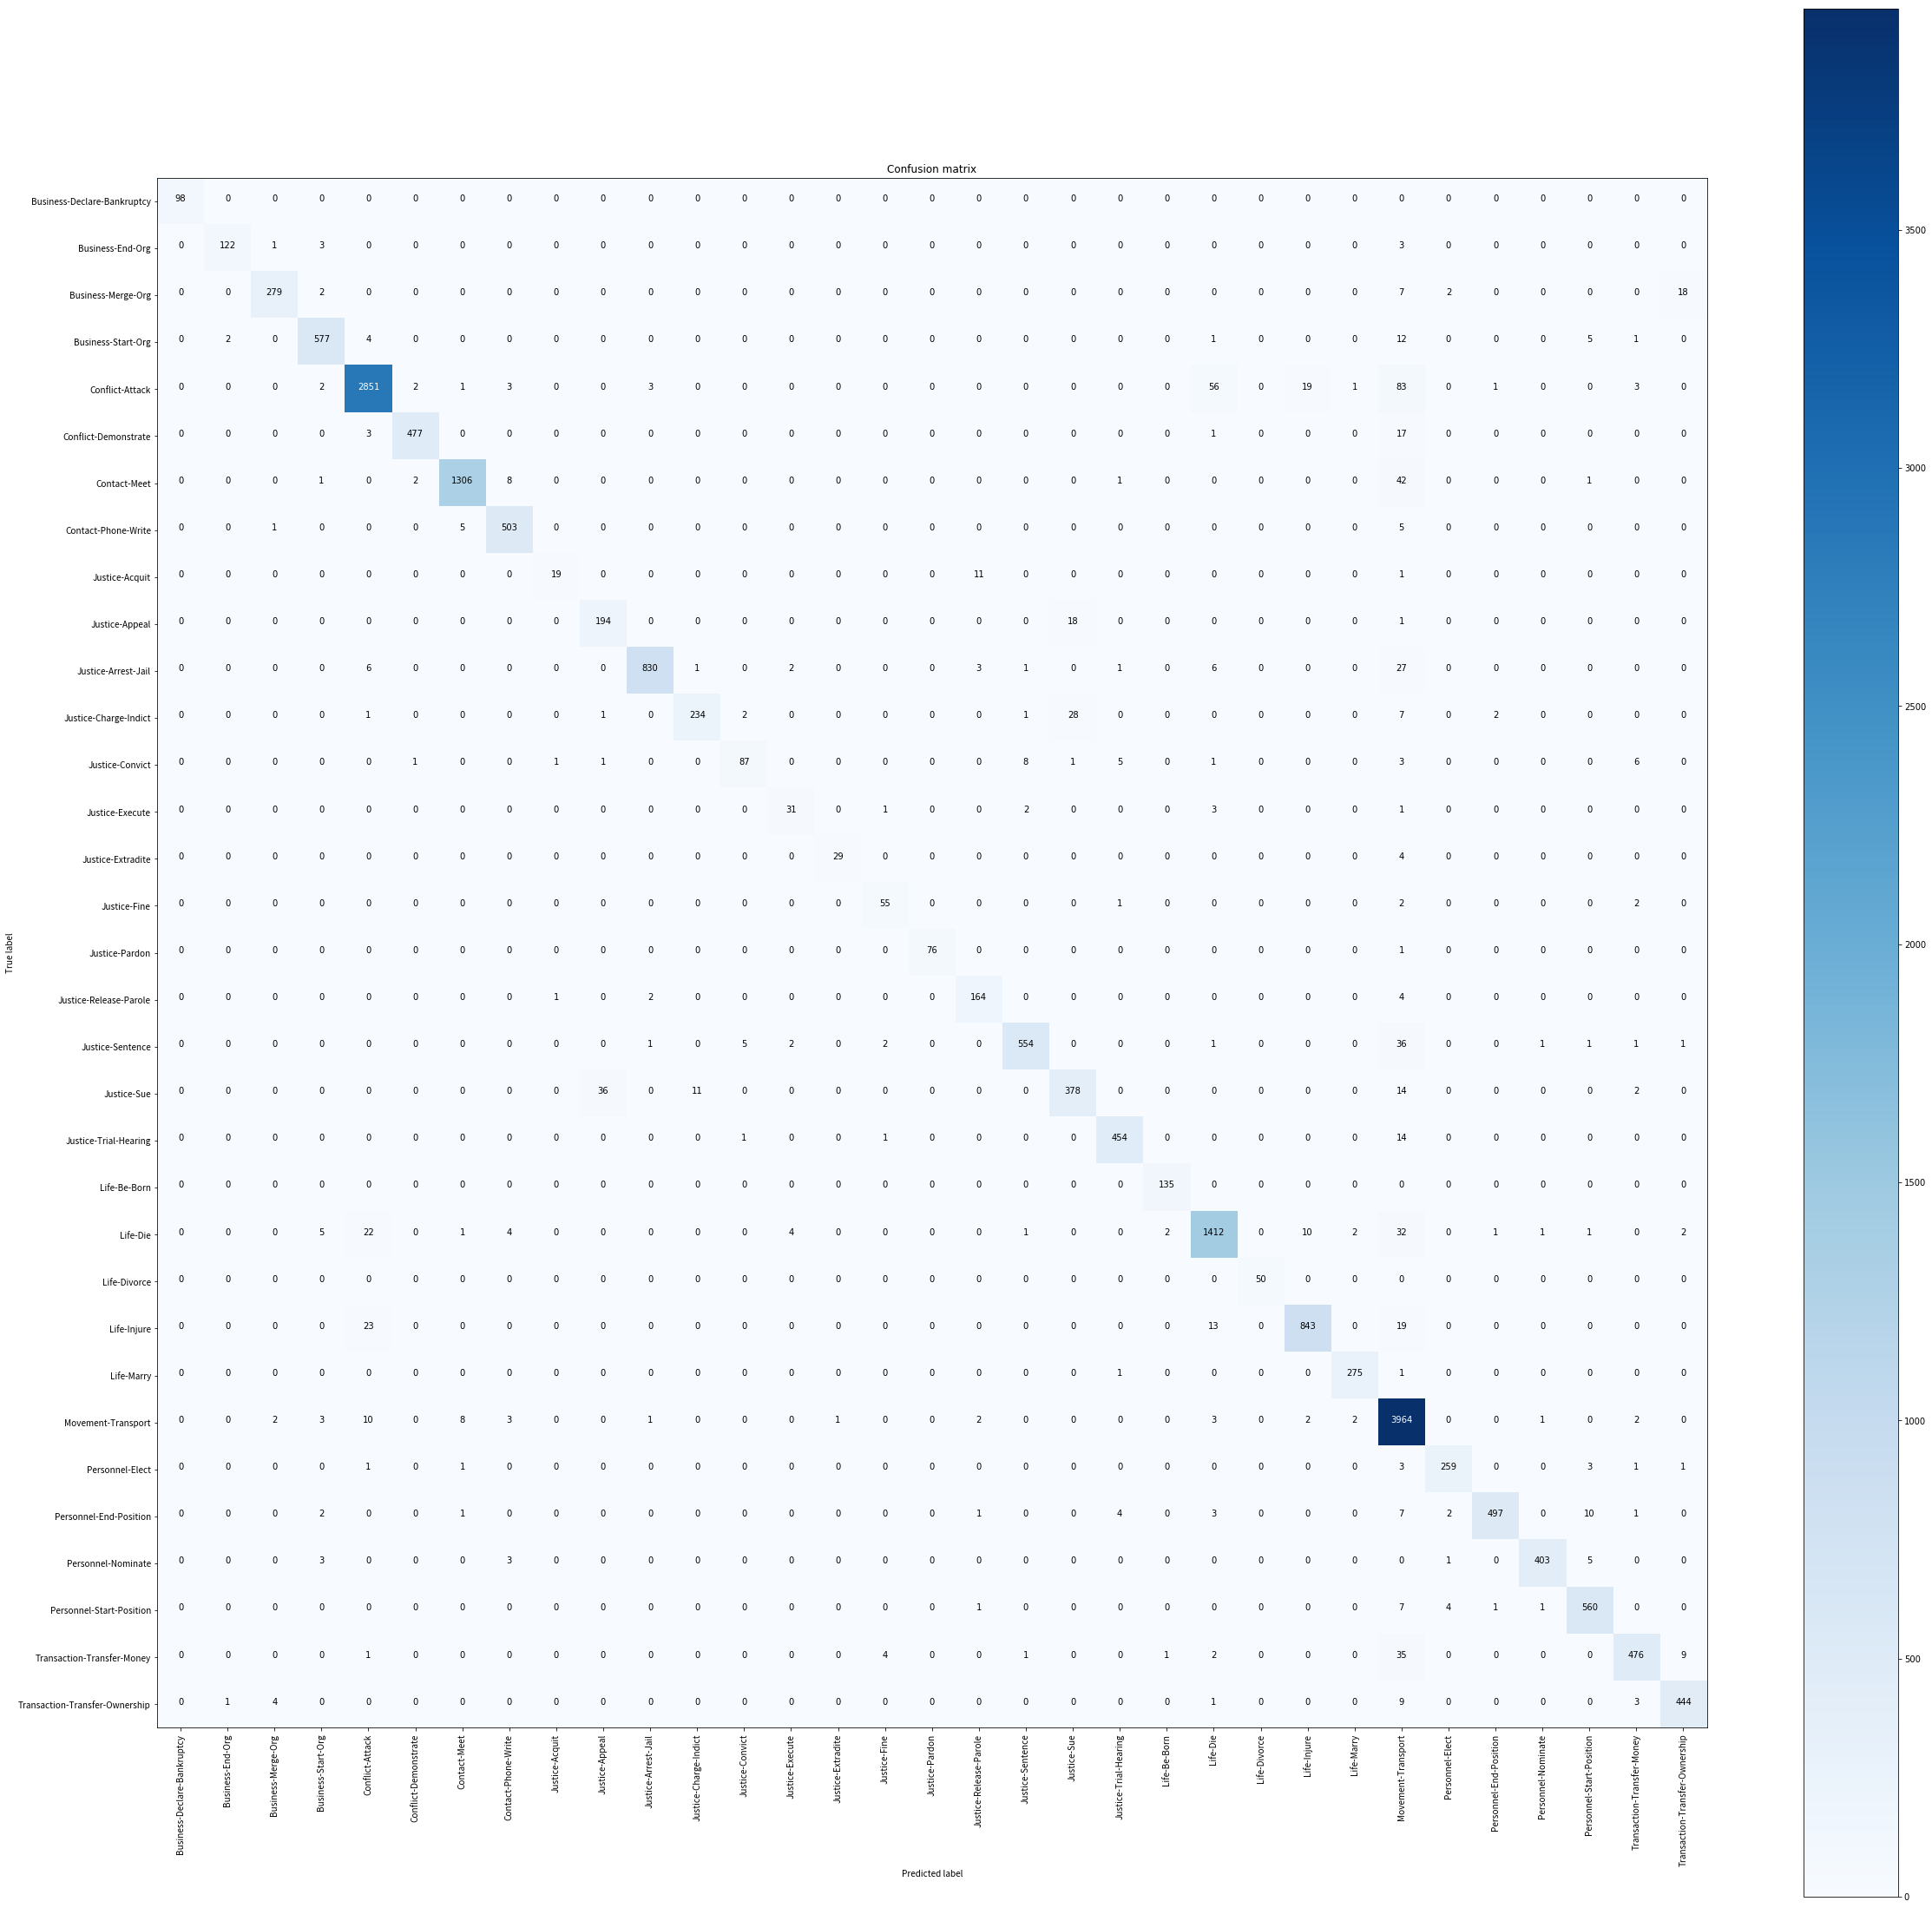

Normalized confusion matrix


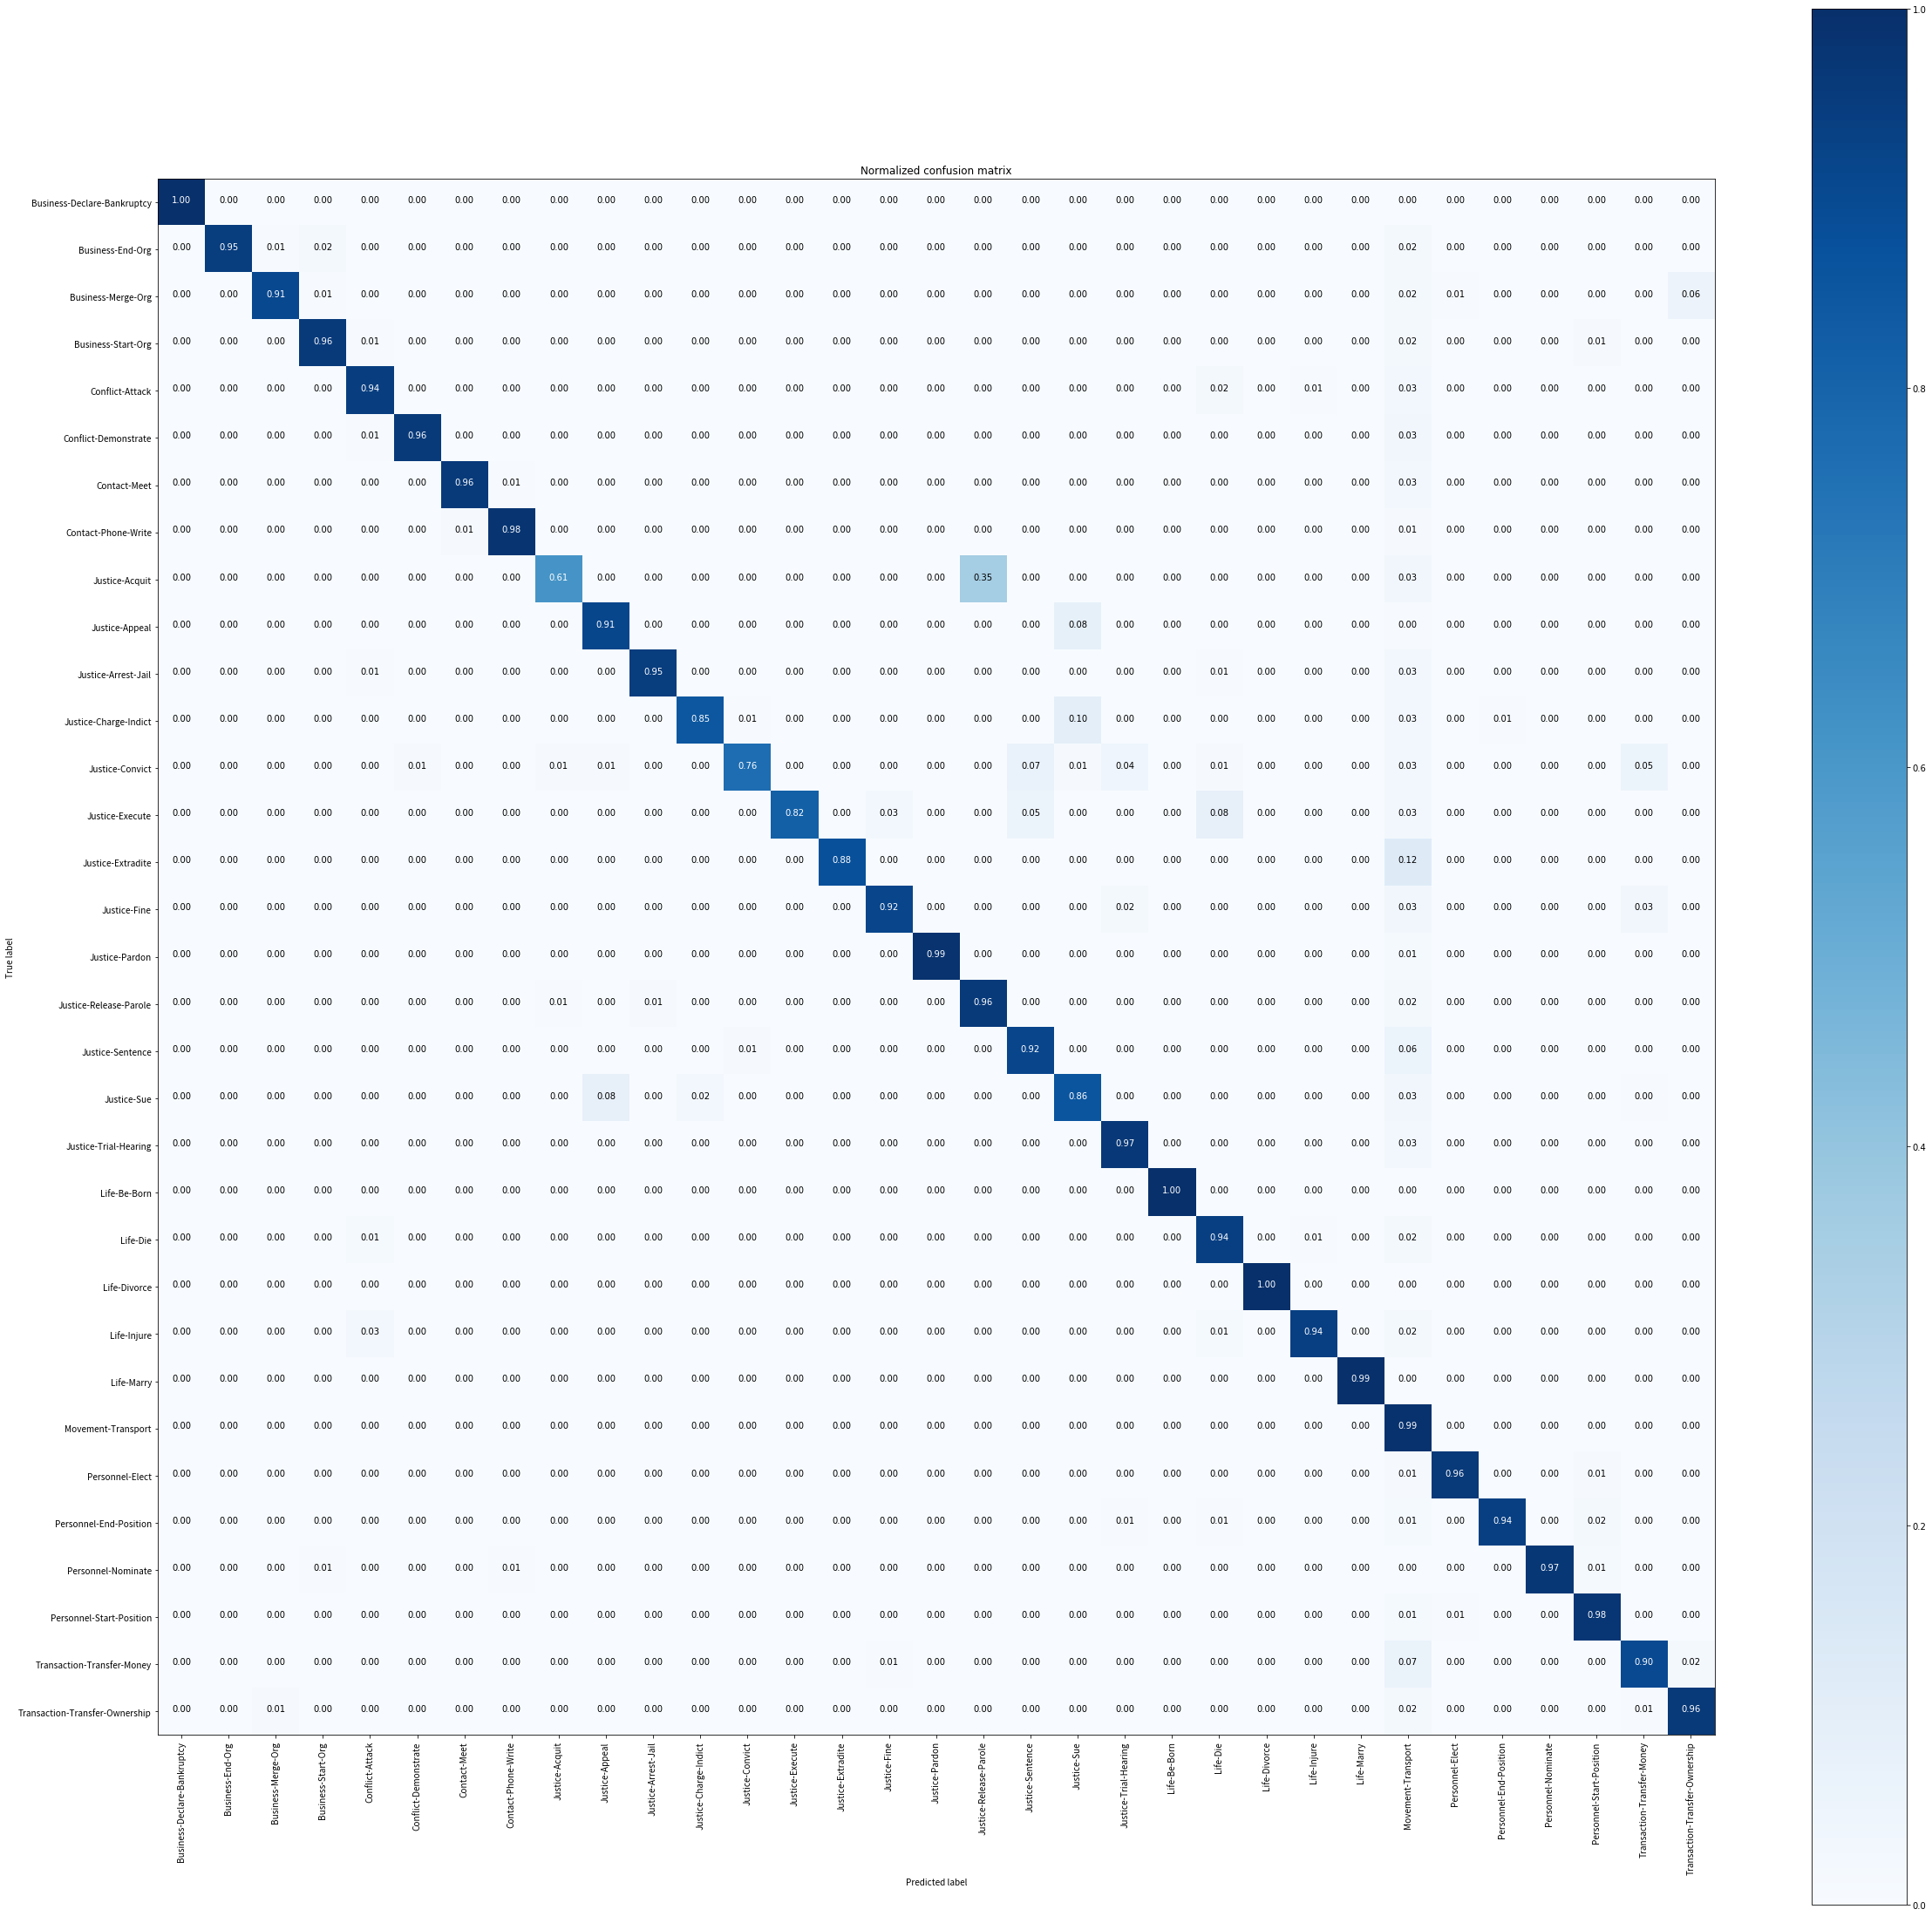

>>evaluating
19582/19582 [==============================] - 2s 101us/step
loss :  0.21278031274439282
accuracy : 0.9516903278581967
triggers extraction accuracy: 0.9516903278581967
>>argument model testing:
>>test the model on given data:
samples: (240750, 1536), 35 labels: {'Prosecutor', 'Recipient', 'Instrument', 'Plaintiff', 'Beneficiary', 'Position', 'Time-Within', 'Giver', 'Buyer', 'Victim', 'Person', 'Vehicle', 'Price', 'Time-Ending', 'Sentence', 'Destination', 'Agent', 'Target', 'Defendant', 'Seller', 'Time-At-Beginning', 'Origin', 'Crime', 'Time-After', 'Money', 'Time-Holds', 'Time-Starting', 'Adjudicator', 'Attacker', 'Entity', 'Time-Before', 'Artifact', 'Time-At-End', 'Place', 'Org'}
>>testing
240750/240750 [==============================] - 18s 74us/step
(240750, 35)
[7158, 6, 1, 3, 0, 0, 8, 115, 15, 43, 2, 0, 0, 2, 1, 12, 20, 42, 3, 0, 28, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[83, 9512, 152, 390, 5, 0, 3, 15, 174, 164, 3, 106, 1, 448, 238, 1712, 305, 0, 6, 0, 0, 0, 0, 

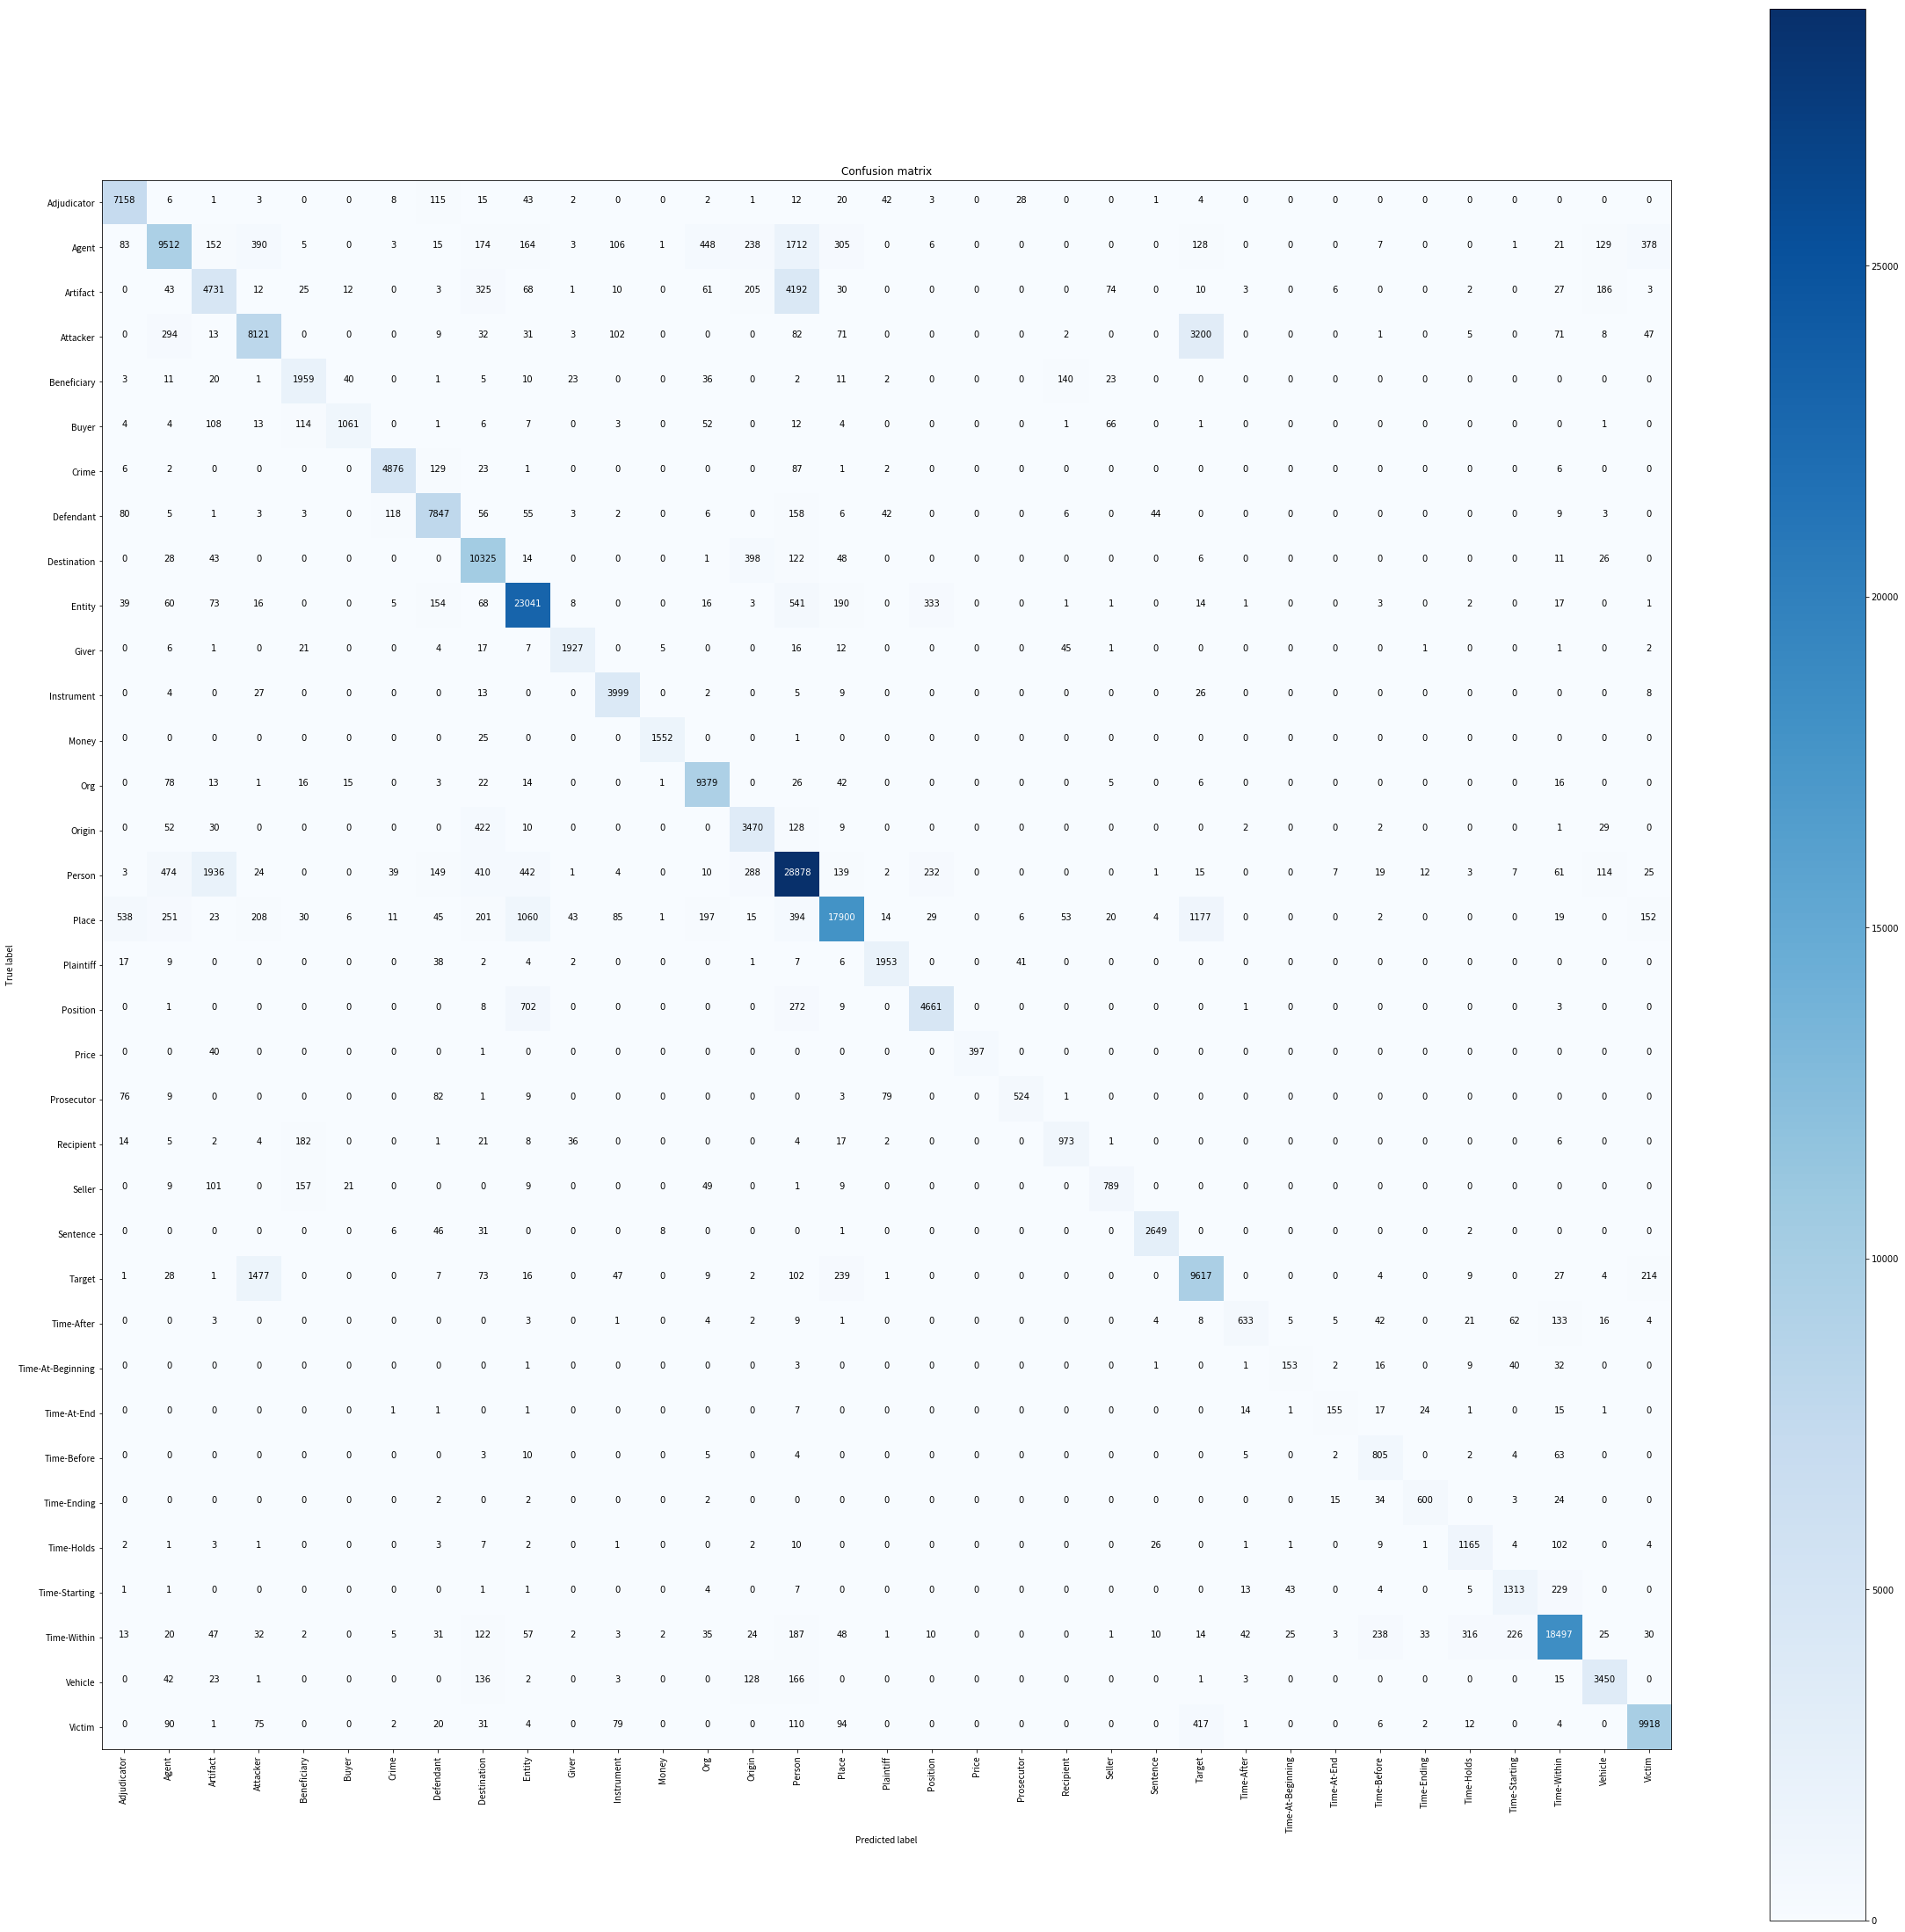

Normalized confusion matrix


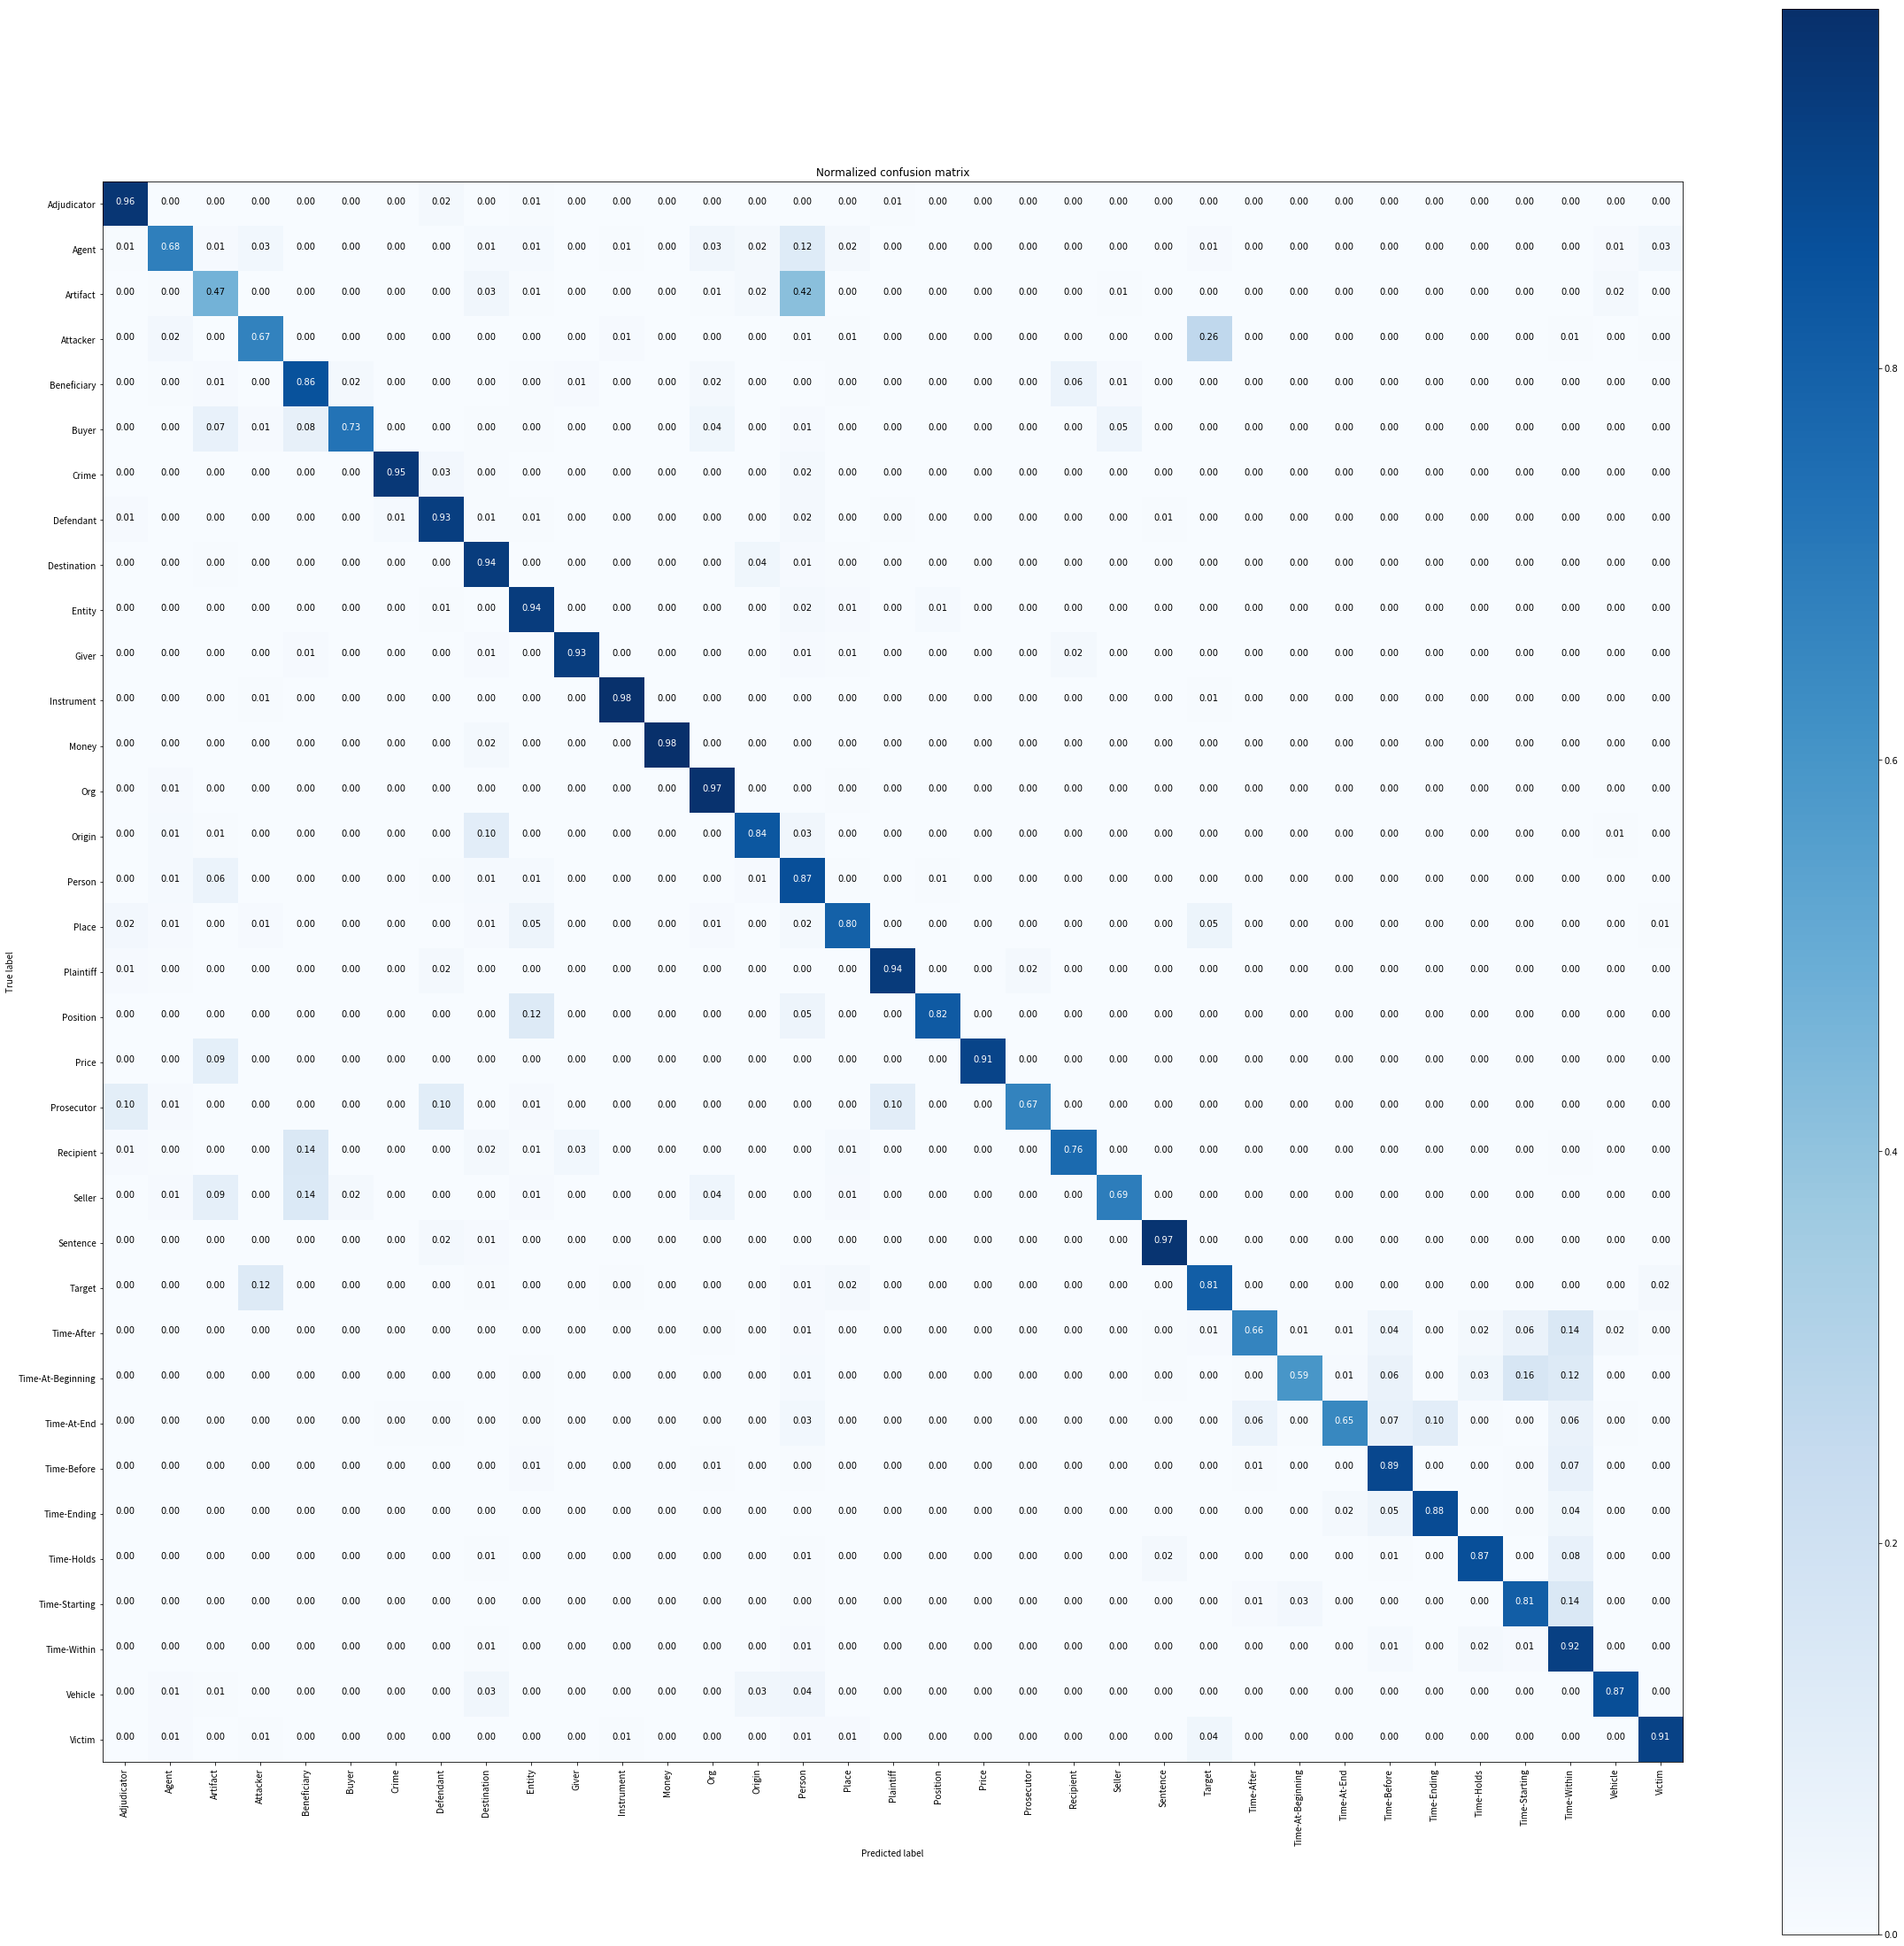

>>evaluating
240750/240750 [==============================] - 35s 147us/step
loss :  0.41504224263520395
accuracy : 0.8473021806858534
arguements extraction accuracy: 0.8473021806858534


In [3]:
#model test
import os
import numpy as np
from sklearn.externals import joblib
from bert_serving.client import BertClient
from bratreader.repomodel import RepoModel
from sklearn.preprocessing import LabelEncoder
#from model_com import create_base_network, get_events, fit_on_data, test_on_data, get_events_in_mention


def testing(DIR_DATA): 
    print('\n\nTesting {}>>>\ndata importing:'.format(DIR_DATA))
    TASK_NAME = DIR_DATA
    NAME_DATA_FILE = TASK_NAME+'_data_import'+'.save'
    DIR_MODEL = './save_test/'
    file_model_trig = DIR_MODEL + TASK_NAME +'_model_trigger.pkl'
    file_model_arg = DIR_MODEL + TASK_NAME + '_model_arg.pkl'

    triggers, vec_trig, label_trig, args, vec_arg, label_arg = [], [], [], [], [], []
    try:
        triggers, vec_trig, label_trig, args, vec_arg, label_arg = joblib.load(NAME_DATA_FILE)
    except:
        ANN_FILEs = []
        DIR_ALL_FILES = os.listdir(DIR_DATA)
        for file_name in DIR_ALL_FILES:
            if file_name.split('.')[-1] == 'txt':
                ANN_FILEs.append(file_name[:-4])
        corpus = RepoModel(DIR_DATA) # load corpus
        bc = BertClient(ip='127.0.0.1', port=8701, port_out=8702, show_server_config=True) # bert model as service
        for ANN_FILE in ANN_FILEs:
            doc = corpus.documents[ANN_FILE] # get document with key
            ttriggers, tvec_trig, tlabel_trig, targs, tvec_arg, tlabel_arg, label_arg_for_each_trig = get_events_in_mention(doc, bc)
            triggers.extend(ttriggers)
            vec_trig.extend(tvec_trig)
            label_trig.extend(tlabel_trig)
            args.extend(targs)
            vec_arg.extend(tvec_arg)
            label_arg.extend(tlabel_arg)
        print('trigs:', len(vec_trig), 'args:', len(vec_arg))
        joblib.dump([triggers, vec_trig, label_trig, args, vec_arg, label_arg], NAME_DATA_FILE)

    
    print('='*65,'\n>>trigger model testing:')
    model_trig, encoder_trig = joblib.load(file_model_trig)
    acc = test_on_data(model_trig, encoder_trig, vec_trig, label_trig, DIR_DATA, en_verbose = EN_verbose)
    print('triggers extraction accuracy: {}'.format(acc))

    print('='*65,'\n>>argument model testing:')
    model_arg, encoder_arg = joblib.load(file_model_arg)
    acc = test_on_data(model_arg, encoder_arg, vec_arg, label_arg, DIR_DATA, en_verbose = EN_verbose)
    print('arguements extraction accuracy: {}'.format(acc))


EN_verbose = 1
DIR_DATAs = ['data_ACE_Chinese'] #'data_test', 'data_ACE_English', 'data_ACE_Chinese'
for DIR_DATA in DIR_DATAs:
    testing(DIR_DATA)


In [ ]:
import os
from sklearn.externals import joblib
from bert_serving.client import BertClient
from bratreader.repomodel import RepoModel
from model_com import get_events, fit_on_data, test_on_data, event_extract, event_extract_kzg, get_events_in_mention

DIR_MODEL = './save_test/'
task = 'data_ACE_Chinese'
file_model_trig = DIR_MODEL + task + '_model_trigger.pkl'
file_model_arg = DIR_MODEL  + task + '_model_arg.pkl'

bc = BertClient(ip='127.0.0.1', port=8701, port_out=8702, show_server_config=False) # bert model as service
model_trig, encoder_trig = joblib.load(file_model_trig)
model_arg, encoder_arg = joblib.load(file_model_arg)

model_trig.summary()
model_arg.summary()

### sents test
#test_sent = "Henry Charles \"Hank\" Stackpole III (born May 7, 1935) is a retired lieutenant general in the United States Marine Corps."
#test_sent = "Kyle Jerome White (born 1987) is a former United States Army soldier, and is the seventh living recipient of the Medal of Honor from the War in Afghanistan."
#test_sent = "加拿大自由党总理克雷蒂安在议会占绝大多数的政府在星期一选举 中，大获全胜，当选 "
test_sent = 'Henry Charles "Hank" Stackpole III (born May 7, 1935) is a retired lieutenant general in the United States Marine Corps.'
ann = event_extract(test_sent, model_trig, encoder_trig, model_arg, encoder_arg, bc)
print(ann)

In [4]:
#model training
import os
import numpy as np
from sklearn.externals import joblib
from bert_serving.client import BertClient
from bratreader.repomodel import RepoModel
from sklearn.preprocessing import LabelEncoder

from keras import backend as K



def training(DIR_DATA): 
    print('\ndata importing:')
    TASK_NAME = DIR_DATA
    NAME_DATA_FILE = TASK_NAME+'_data_import'+'.save'



    DIR_MODEL = './save_test/'
    file_model_trig = DIR_MODEL + TASK_NAME +'_model_trigger.pkl'
    file_model_arg = DIR_MODEL + TASK_NAME + '_model_arg.pkl'
    triggers, vec_trig, label_trig, args, vec_arg, label_arg = [], [], [], [], [], []
    try:
        triggers, vec_trig, label_trig, args, vec_arg, label_arg = joblib.load(NAME_DATA_FILE)
        args, vec_arg, label_arg = None, None, None
    except:
        corpus = RepoModel(DIR_DATA) # load corpus
        bc = BertClient(ip='127.0.0.1', port=8701, port_out=8702, show_server_config=True) # bert model as service
        
        # obtain all the files list
        ANN_FILEs = []
        DIR_ALL_FILES = os.listdir(DIR_DATA)
        for file_name in DIR_ALL_FILES:
            if file_name.split('.')[-1] == 'txt':
                ANN_FILEs.append(file_name[:-4])
        for ANN_FILE in ANN_FILEs:
            doc = corpus.documents[ANN_FILE] # get document with key
            ttriggers, tvec_trig, tlabel_trig, targs, tvec_arg, tlabel_arg, label_arg_for_each_trig = get_events_in_mention(doc, bc)
            triggers.extend(ttriggers)
            vec_trig.extend(tvec_trig)
            label_trig.extend(tlabel_trig)
            args.extend(targs)
            vec_arg.extend(tvec_arg)
            label_arg.extend(tlabel_arg)

        print('trigs:', len(vec_trig), 'args:', len(vec_arg))
        joblib.dump([triggers, vec_trig, label_trig, args, vec_arg, label_arg], NAME_DATA_FILE)
        args, vec_arg, label_arg = None, None, None


    N_batchs =[len(label_trig), 8192, 4096, 2048, 1024, 512, 32, 16, 8, 4, 2, 1]
    N_batchs =[8]
    lrs = [0.01]
    N_trains = 8
    N_epochs = 4
    
    
    print('='*65,'\n>>trigger model training:')
    try:
        model_trig, encoder_trig = joblib.load(file_model_trig)
        acc_pre = test_on_data(model_trig, encoder_trig, vec_trig, label_trig, DIR_DATA, en_verbose = 0)
    except:
        # model define
        input_dim = np.asarray(vec_trig).shape[1]
        N_classes = len(set(label_trig))
        model_trig = create_base_network(input_dim, N_classes)
        encoder_trig = LabelEncoder()
        encoder_trig.fit(label_trig)
        acc_pre = 0

    for N_batch in N_batchs:
        for lr in lrs:
            Times_training, N_batch, N_epoch, en_verbose = N_trains, N_batch, max(N_epochs, int(np.floor(np.sqrt(10*N_batch)))), 1
            for times in range(1, Times_training):
                the_lr = lr/times
                model_trig, encoder_trig, his = fit_on_data(vec_trig, label_trig, model_trig, encoder_trig, 
                                                            the_lr, N_batch = N_batch, N_epoch = N_epoch, en_verbose = en_verbose)
                print('acc:{}'.format(his.history['acc'][-1]))
                val_acc = test_on_data(model_trig, encoder_trig, vec_trig, label_trig, DIR_DATA, en_verbose = en_verbose)
                joblib.dump([model_trig,encoder_trig], '{}_{:.5f}_{:.5f}_{:.5f}_{:.5f}.pkl'.format(
                    file_model_trig[0:-4], his.history['acc'][-1], val_acc, the_lr, N_batch)) # save the model to disk
                if val_acc > acc_pre:
                    acc_pre = val_acc
                    joblib.dump([model_trig,encoder_trig], '{}.pkl'.format(file_model_trig[0:-4])) # save the model to disk
                else:
                    break

    print('='*65,'\n>>argument model training:')
    try:
        triggers, vec_trig, label_trig = None, None, None
        triggers, vec_trig, label_trig, args, vec_arg, label_arg = joblib.load(NAME_DATA_FILE)
        triggers, vec_trig, label_trig = None, None, None
        model_arg, encoder_arg = joblib.load(file_model_arg)
        acc_pre = test_on_data(model_arg, encoder_arg, vec_arg, label_arg, DIR_DATA, en_verbose = 0)
    except:
        encoder_arg = LabelEncoder()
        encoder_arg.fit(label_arg)
        # model define
        input_dim = np.asarray(vec_arg).shape[1]
        N_classes = len(set(label_arg))
        model_arg = create_base_network(input_dim, N_classes)
        acc_pre = 0

    for lr in lrs:
        for N_batch in N_batchs:
            Times_training, N_batch, N_epoch, en_verbose = N_trains, N_batch, max(N_epochs, int(np.floor(np.sqrt(10*N_batch)))), 1
            for times in range(1, Times_training):
                the_lr = lr/times
                model_arg, encoder_arg, his = fit_on_data(vec_arg, label_arg, model_arg, encoder_arg, 
                                                          the_lr, N_batch = N_batch, N_epoch = N_epoch, en_verbose = en_verbose)
                print('acc:{}'.format(his.history['acc'][-1]))
                val_acc = test_on_data(model_arg, encoder_arg, vec_arg, label_arg, DIR_DATA, en_verbose = en_verbose)
                joblib.dump([model_arg,encoder_arg], '{}_{:.5f}_{:.5f}_{:.5f}_{:.5f}.pkl'.format(
                    file_model_arg[0:-4], his.history['acc'][-1], val_acc, the_lr, N_batch)) # save the model to disk
                if val_acc > acc_pre:
                    acc_pre = val_acc
                    joblib.dump([model_arg,encoder_arg], '{}.pkl'.format(file_model_arg[0:-4])) # save the model to disk
                else:
                    break



DIR_DATAs = ['data_test', 'data_military-corpus', 'data_ACE_English', 'data_ACE_Chinese', 'data_ACE']
DIR_DATAs = ['data_ACE_Chinese']
for DIR_DATA in DIR_DATAs:
    training(DIR_DATA)


data importing:


KeyboardInterrupt: 

In [ ]:
# error analysis and Retrain
label_pred =  np.argmax(probs, axis=1)
label_true = np.argmax(Y_encoder, axis=1)
predict_diff = abs(label_pred - label_true)
idx_diff = np.where(predict_diff>0)
print(idx_diff[0])
for idx in idx_diff[0]:
    print(idx, '\t', spans[idx], '\t', wordslabel[idx], '\t', words[idx])

Times_wrong =  40
data_wrong = np.tile(wordsvec[idx_diff[0]], (Times_wrong, 1))
label_wrong = np.tile(Y_encoder[idx_diff[0]], (Times_wrong, 1))
data_retrain = np.append(wordsvec, data_wrong, axis = 0)
label_retrain = np.append(Y_encoder, label_wrong, axis =0)
print(data_retrain.shape, label_retrain.shape)



X_train, X_test, Y_train, Y_test = train_test_split(data_retrain, label_retrain, random_state=0)

# model define
N_batch = 8
N_epoch = 100
en_verbose = 0
input_dim = wordsvec.shape[1]
N_classes = len(set(wordslabel))

model = create_base_network(input_dim, N_classes)
model.summary()

# model training
print('='*65,'\n>>training')
start   = time.time()
history = model.fit(X_train, Y_train,
                    batch_size=N_batch, epochs=N_epoch,
                    verbose=en_verbose, validation_data=(X_test, Y_test))
end     = time.time()
print('time elapse training:\t', end - start, 'sec') 

# model test
print('='*65,'\n>>testing')
probs = model.predict(X_test, verbose=1)

# model eval
print('='*65,'\n>>evaluating')
probs = model.predict(wordsvec, verbose=1)
#Returns the loss value & metrics values for the model in test mode.
[loss, metrics] = model.evaluate(x=wordsvec, y=Y_encoder, verbose=1)
print('loss : ', loss)
print(model.metrics[0], ':', metrics)


# error analysis
label_pred = np.argmax(probs, axis=1)
label_true = np.argmax(Y_encoder, axis=1)
predict_diff = abs(label_pred - label_true)
idx_diff = np.where(predict_diff>0)
for idx in idx_diff[0]:
    print(idx, '\t', spans[idx], '\t', wordslabel[idx], '\t', words[idx])

In [ ]:

import os

CLASSPATH = "$CLASSPATH:"
path_standford = '/home/linbo/workspace/Datasets/Standford-coreNLP/'
path_segmenter = path_standford + 'stanford-segmenter-2018-10-16/stanford-segmenter.jar'
CLASSPATH = CLASSPATH + path_segmenter

path_postagger = path_standford + 'stanford-postagger-full-2018-10-16/stanford-postagger.jar'
CLASSPATH = CLASSPATH + ':' + path_postagger

path_ner = path_standford + 'stanford-ner-2018-10-16/stanford-ner.jar'
CLASSPATH = CLASSPATH + ':' + path_ner

path_parser = path_standford + 'stanford-parser-full-2018-10-17/stanford-parser.jar'
CLASSPATH = CLASSPATH + ':' + path_parser

path_parser_model = path_standford + 'stanford-parser-full-2018-10-17/stanford-parser-3.9.2-models.jar'
CLASSPATH = CLASSPATH + ':' + path_parser_model

path_corenlp = path_standford + 'stanford-corenlp-full-2018-10-05/stanford-corenlp-3.9.2.jar:' 
CLASSPATH = CLASSPATH + ':' + path_corenlp

path_model = path_standford + 'stanford-english-corenlp-2018-10-05-models.jar'
#path_model = path_standford + 'stanford-corenlp-full-2018-10-05/stanford-corenlp-3.9.2-models.jar'
CLASSPATH = CLASSPATH + ':' + path_model

path_api = path_standford + 'stanford-corenlp-full-2018-10-05/slf4j-api.jar'
CLASSPATH = CLASSPATH + ':' + path_api

print(CLASSPATH)

os.environ["CLASSPATH"] = CLASSPATH
os.environ['STANFORD_PARSER'] = path_corenlp
os.environ['STANFORD_MODELS'] = path_model

In [ ]:
sent = "Kalla, it\'s a dog!"

from nltk.tokenize.stanford import StanfordTokenizer

tokenizer = StanfordTokenizer()
print(tokenizer.tokenize(sent))

In [ ]:

from nltk.parse.stanford import StanfordParser

class MyParser(StanfordParser):
    def raw_parse_sents(self, sentences, verbose=False):
        """
        Use StanfordParser to parse multiple sentences. Takes multiple sentences as a
        list of strings.
        Each sentence will be automatically tokenized and tagged by the Stanford Parser.
        The output format is `wordsAndTags`.

        :param sentences: Input sentences to parse
        :type sentences: list(str)
        :rtype: iter(iter(Tree))
        """
        cmd = [
            self._MAIN_CLASS,
            '-model', self.model_path,
            '-outputFormat', 'penn', # conll, conll2007, penn
            '-sentences', 'newline'
        ]
        return self._parse_trees_output(self._execute(cmd, '\n'.join(sentences), True ))
myparser = MyParser(model_path= path_standford + 'stanford-english-corenlp-2018-10-05-models/' 
                    + "edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz")

en_GUI = 0
sent = "the quick brown fox jumps over the \" lazy \" dog ."
print(sent)
res = list(myparser.raw_parse_sents([sent, sent]))
for row in res:
    for t in row:
        print(type(t),'\n',t)
        if  en_GUI:
            t.draw()

In [ ]:
from nltk.corpus import BracketParseCorpusReader

reader = BracketParseCorpusReader("./data/", "temp.txt")
for sent in reader.parsed_sents():
    print(sent)
t = sent
for s in t.subtrees(lambda t: t.height() == 2): print(s)


from nltk.tree import Tree

t = Tree.fromstring("(S (NP (D the) (N dog)) (VP (V chased) (NP (D the) (N cat))))")
for s in t.subtrees(lambda t: t.height() == 2): print(s)

In [ ]:
from collections import OrderedDict
from nltk.tree import Tree
from nltk.parse.stanford import StanfordParser

class MyParser(StanfordParser):
    def raw_parse_sents(self, sentences, verbose=False):
        """
        Use StanfordParser to parse multiple sentences. Takes multiple sentences as a
        list of strings.
        Each sentence will be automatically tokenized and tagged by the Stanford Parser.
        The output format is `penn`.

        :param sentences: Input sentences to parse
        :type sentences: list(str)
        :rtype: iter(iter(Tree))
        """
        cmd = [
            self._MAIN_CLASS,
            '-model', self.model_path,
            '-outputFormat', 'penn', # conll, conll2007, penn
            '-sentences', 'newline'
        ]
        return self._parse_trees_output(self._execute(cmd, '\n'.join(sentences), True ))
myparser = MyParser(model_path= path_standford + 'stanford-english-corenlp-2018-10-05-models/' 
                    + "edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz")

def load_tags(file_tags):
    tags = OrderedDict()
    with open(file_tags, encoding='utf-8') as ft:
        for line in ft.readlines():
            line = line.strip()
            tags[line] = len(tags)
    return tags

tags = load_tags('tags.csv')

sent = "the quick brown fox jumps over the \" lazy \" dog ."
print(sent)
res = list(myparser.raw_parse_sents(['1 ' + sent, '2 ' + sent]))
for row in res:
    for t in row: 
        x = {s[0]:tags[s.label()] for s in t.subtrees(lambda t: t.height() == 2)}
        print(x)